In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import os

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# #1.1 Data augmentation pipeline
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.5),
    layers.RandomZoom(0.4),
    layers.RandomTranslation(0.3, 0.3),
    layers.RandomContrast(0.5),
    layers.RandomBrightness(0.5),
    layers.GaussianNoise(0.1),
])

# Normalization layer
normalization_layer = layers.Rescaling(1./255)

#1.2 Load data
train_ds = keras.utils.image_dataset_from_directory(
    "dataset-v2/dataset_classified_split/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    color_mode="rgb"
)
val_ds = keras.utils.image_dataset_from_directory(
    "dataset-v2/dataset_classified_split/val",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    color_mode="rgb"
)
test_ds = keras.utils.image_dataset_from_directory(
    "dataset-v2/dataset_classified_split/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    color_mode="rgb"
)

# 1.3 Apply augmentation and normalization
train_ds = train_ds.map(lambda x, y: (normalization_layer(data_augmentation(x)), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

Found 780 files belonging to 3 classes.
Found 196 files belonging to 3 classes.
Found 245 files belonging to 3 classes.


In [2]:
#2.1 Compute class weights (using your exact code)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1, 2]),  # Convert to numpy array
    y=np.array([0] * 339 + [1] * 312 + [2] * 129)  # Convert to numpy array
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

print(f"Class weights: {class_weights}")

#2.2 Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    keras.callbacks.ModelCheckpoint(
        'checkpoints/cnn-transformer/stage1_frozen_backbone1.weights.h5',
        save_weights_only=True,
        save_best_only=True,
        monitor='val_accuracy'
    )
]

Class weights: {0: np.float64(0.7669616519174042), 1: np.float64(0.8333333333333334), 2: np.float64(2.0155038759689923)}


In [3]:
#3.1 Build ResNet-ViT Hybrid Model
num_classes = 3

def simple_true_hybrid(num_classes, input_shape=(224, 224, 3)):
    inputs = keras.Input(shape=input_shape)

    # ResNet backbone
    base_model = keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        name="resnet_base"
    )

    # Freeze early layers
    for layer in base_model.layers[:100]:
        layer.trainable = False

    # Get features and convert to patches
    features = base_model.output  # 7x7x2048
    x = layers.Conv2D(512, kernel_size=1, activation='relu')(features)  # 7x7x512
    x = layers.Reshape((49, 512))(x)  # 49 patches

    # Minimal transformer (single attention head)
    x = layers.MultiHeadAttention(num_heads=1, key_dim=512)(x, x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs=inputs, outputs=outputs)

# Compile with slightly higher LR
model = simple_true_hybrid(num_classes=num_classes)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-5),  # Increased from 1e-5
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


# Build and compile
model = simple_true_hybrid(num_classes=num_classes)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,688,963 (98.00 MB)

 Trainable params: 21,554,179 (82.22 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

In [4]:
# Train the model
EPOCHS = 40

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Save the weights
model.save_weights('checkpoints/cnn-transformer/hybrid_resnet_vit_weights2.weights.h5')
print("Saved hybrid ResNet-ViT weights.")

# Optional: Save the entire model
model.save('checkpoints/cnn-transformer/hybrid_resnet_vit_model2.keras')
print("Saved complete hybrid ResNet-ViT model.")

Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.3628 - loss: 1.1026 - val_accuracy: 0.1633 - val_loss: 1.1582 - learning_rate: 1.0000e-04
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.4038 - loss: 1.0598 - val_accuracy: 0.4490 - val_loss: 1.0856 - learning_rate: 1.0000e-04
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.4256 - loss: 1.0156 - val_accuracy: 0.4337 - val_loss: 1.0488 - learning_rate: 1.0000e-04
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.4449 - loss: 0.9793 - val_accuracy: 0.4388 - val_loss: 0.9945 - learning_rate: 1.0000e-04
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.4692 - loss: 0.9677 - val_accuracy: 0.4388 - val_loss: 1.0415 - learning_rate: 1.0000e-04
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.4885 - loss: 0.9308 - val_accuracy: 0.4541 - val_loss: 0.9567 - learning_rate: 1.0000e-04
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.5115 - loss:

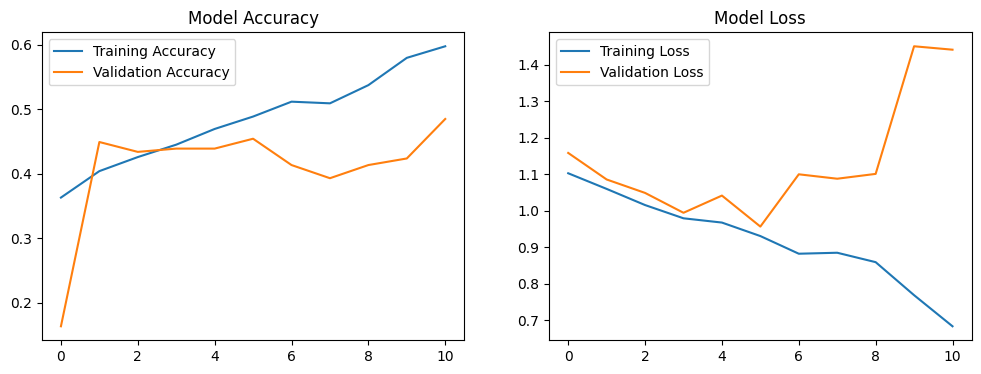

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [7]:
# Continue training for 10-15 more epochs
history_continue = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,  # Continue to epoch 25 total
    class_weight=class_weights,
    callbacks=callbacks,
    initial_epoch=11  # Start from epoch 11
)

Epoch 12/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.5308 - loss: 0.8408 - val_accuracy: 0.4133 - val_loss: 1.0237 - learning_rate: 5.0000e-05
Epoch 13/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.5718 - loss: 0.7695 - val_accuracy: 0.4286 - val_loss: 1.1083 - learning_rate: 5.0000e-05
Epoch 14/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.5628 - loss: 0.7434 - val_accuracy: 0.4388 - val_loss: 1.9194 - learning_rate: 5.0000e-05
Epoch 15/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.6244 - loss: 0.6380 - val_accuracy: 0.4235 - val_loss: 3.4536 - learning_rate: 2.5000e-05
Epoch 16/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.6859 - loss: 0.5567 - val_accuracy: 0.5051 - val_loss: 1.5892 - learning_rate: 2.5000e-05


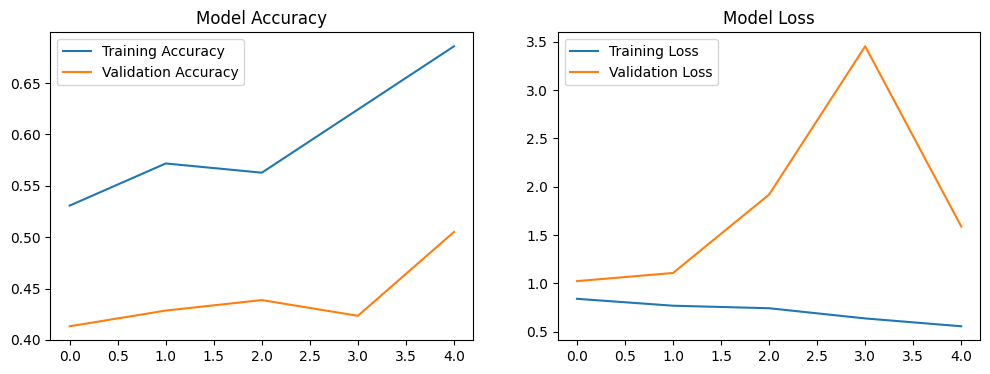

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_continue.history['accuracy'], label='Training Accuracy')
plt.plot(history_continue.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_continue.history['loss'], label='Training Loss')
plt.plot(history_continue.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

In [19]:
# Save the weights
model.save_weights('checkpoints/cnn-transformer/hybrid_resnet_vit_weights_stage2.weights.h5')
print("Saved hybrid ResNet-ViT weights.")

# Optional: Save the entire model
model.save('checkpoints/cnn-transformer/hybrid_resnet_vit_model_stage2.keras')
print("Saved complete hybrid ResNet-ViT model.")

Saved hybrid ResNet-ViT weights.
Saved complete hybrid ResNet-ViT model.


In [4]:
model.load_weights('checkpoints/cnn-transformer/real/hybrid_resnet_vit_weights_stage2.weights.h5')
print("Loaded previous weights.")

Loaded previous weights.


c:\Users\ksan\Documents\thesis\automated-thermal-burn-severity-classifyer\.venv-training\lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 206 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [6]:
# STAGE 2: Fine-tuning
print("Starting Stage 2: Fine-tuning...")

for layer in model.layers[-30:]:
    layer.trainable = True

# 2. Lower learning rate for fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),  # Lower LR
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3. Updated callbacks for fine-tuning
stage2_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=8,
        restore_best_weights=True,
        mode='max'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=4,
        mode='max',
        min_lr=1e-7
    ),
    keras.callbacks.ModelCheckpoint(
        'checkpoints/cnn-transformer/stage2_finetuned.weights.h5',
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'
    )
]

# 4. Train Stage 2
print("Starting Stage 2 training...")
history_stage2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=stage2_callbacks,
    verbose=1
)

# 5. Final evaluation
print("Final evaluation...")
test_loss_final, test_acc_final = model.evaluate(test_ds)
print(f"Final Test Accuracy: {test_acc_final:.4f}")

# Save model
model.save_weights('checkpoints/cnn-transformer/stage2_hybrid_model.weights.h5')
model.save('checkpoints/cnn-transformer/stage2_hybrid_model.keras')
print("Stage 2 complete! model saved.")

Starting Stage 2: Fine-tuning...
Starting Stage 2 training...
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4268 - loss: 1.1652

25/25 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.4526 - loss: 1.0877 - val_accuracy: 0.4388 - val_loss: 1.0051 - learning_rate: 1.0000e-05
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.4590 - loss: 0.9991 - val_accuracy: 0.4337 - val_loss: 0.9806 - learning_rate: 1.0000e-05
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.4782 - loss: 0.9657 - val_accuracy: 0.4388 - val_loss: 0.9575 - learning_rate: 1.0000e-05
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4779 - loss: 0.9391

25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.5103 - loss: 0.9248 - val_accuracy: 0.4439 - val_loss: 0.9519 - learning_rate: 1.0000e-05
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5090 - loss: 0.8935

25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.5154 - loss: 0.8846 - val_accuracy: 0.4796 - val_loss: 0.9336 - learning_rate: 1.0000e-05
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5261 - loss: 0.8545

25/25 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.5436 - loss: 0.8437 - val_accuracy: 0.5102 - val_loss: 0.9287 - learning_rate: 1.0000e-05
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.5756 - loss: 0.7699 - val_accuracy: 0.4949 - val_loss: 0.9479 - learning_rate: 1.0000e-05
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6244 - loss: 0.7007 - val_accuracy: 0.4694 - val_loss: 0.9936 - learning_rate: 1.0000e-05
Epoch 9/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.6500 - loss: 0.6230 - val_accuracy: 0.5000 - val_loss: 1.0039 - learning_rate: 1.0000e-05
Epoch 10/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.6833 - loss: 0.5597 - val_accuracy: 0.4796 - val_loss: 1.0588 - learning_rate: 1.0000e-05
Epoch 11/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7090 - loss: 0.4985 - val_accuracy: 0.4643 - val_loss: 1.0546 - learning_rate: 5.0000e-06
Epoch 12/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.7487 - loss: 0.4664 

OUTPUT FACKEN SUCKS. NEEDS TO REVISE AGAIN FROM STAGE 1 WEIGHTS.

In [8]:
# 1. RELOAD BEST STAGE 1 WEIGHTS
model.load_weights('checkpoints/cnn-transformer/real/hybrid_resnet_vit_weights_stage2.weights.h5')
print("Rolled back to best Stage 1 weights")

# 2. MUCH MORE CONSERVATIVE STAGE 2
# Unfreeze ONLY last 5 layers initially
for layer in model.layers[-5:]:
    layer.trainable = True

# 3. VERY LOW learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-6),  # Much lower
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 4. SHORT fine-tuning
print("restarting Stage 2...")
history_stage2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,  # Only 15 epochs
    class_weight=class_weights,
    callbacks=stage2_callbacks,
    verbose=1
)

Rolled back to best Stage 1 weights
restarting Stage 2...
Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.4462 - loss: 1.1099 - val_accuracy: 0.4235 - val_loss: 1.0295 - learning_rate: 5.0000e-06
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.4487 - loss: 1.0208 - val_accuracy: 0.4184 - val_loss: 0.9864 - learning_rate: 5.0000e-06
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.4667 - loss: 0.9918 - val_accuracy: 0.4388 - val_loss: 0.9658 - learning_rate: 5.0000e-06
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.4833 - loss: 0.9701 - val_accuracy: 0.4439 - val_loss: 0.9521 - learning_rate: 5.0000e-06
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.4923 - loss: 0.9428 - val_accuracy: 0.4388 - val_loss: 0.9413 - learning_rate: 2.5000e-06
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.5026 - loss: 0.9351 - val_accuracy: 0.4490 - val_loss: 0.9316 - learning_rate: 2.5000e-06
Epoch 7/15
25/25 ━

In [9]:
# 1. First, unfreeze ALL BatchNormalization layers (MOST IMPORTANT!)
for layer in model.layers:
    if 'batch_normalization' in layer.name or 'bn' in layer.name:
        layer.trainable = True
        print(f"Unfroze BatchNorm: {layer.name}")

# 2. Unfreeze last 30 layers of ResNet backbone
base_model = model.layers[1]  # Get the ResNet base model
for layer in base_model.layers[-30:]:
    layer.trainable = True
    print(f"Unfroze ResNet layer: {layer.name}")

print(f"✅ Unfroze {sum([1 for l in model.layers if l.trainable])} trainable layers")

# 3. PROPER Learning Rate (100x higher!)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),  # AGGRESSIVE
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 4. AGGRESSIVE Training
print("🚀 Starting AGGRESSIVE Phase 1 training...")
history_phase1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=8,
            restore_best_weights=True,
            mode='max'
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.5,
            patience=4,
            mode='max',
            min_lr=1e-6
        ),
        keras.callbacks.ModelCheckpoint(
            'checkpoints/cnn-transformer/aggressive_phase1.weights.h5',
            save_best_only=True,
            monitor='val_accuracy',
            mode='max'
        )
    ],
    verbose=1
)

# 5. Immediate evaluation
print("📊 Evaluating aggressive phase...")
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"🎯 Phase 1 Test Accuracy: {test_acc:.4f}")

# Save progress
model.save_weights('checkpoints/cnn-transformer/after_aggressive_phase1.weights.h5')
print("💾 Saved Phase 1 weights")

Unfroze BatchNorm: conv1_bn
Unfroze BatchNorm: conv2_block1_1_bn
Unfroze BatchNorm: conv2_block1_2_bn
Unfroze BatchNorm: conv2_block1_0_bn
Unfroze BatchNorm: conv2_block1_3_bn
Unfroze BatchNorm: conv2_block2_1_bn
Unfroze BatchNorm: conv2_block2_2_bn
Unfroze BatchNorm: conv2_block2_3_bn
Unfroze BatchNorm: conv2_block3_1_bn
Unfroze BatchNorm: conv2_block3_2_bn
Unfroze BatchNorm: conv2_block3_3_bn
Unfroze BatchNorm: conv3_block1_1_bn
Unfroze BatchNorm: conv3_block1_2_bn
Unfroze BatchNorm: conv3_block1_0_bn
Unfroze BatchNorm: conv3_block1_3_bn
Unfroze BatchNorm: conv3_block2_1_bn
Unfroze BatchNorm: conv3_block2_2_bn
Unfroze BatchNorm: conv3_block2_3_bn
Unfroze BatchNorm: conv3_block3_1_bn
Unfroze BatchNorm: conv3_block3_2_bn
Unfroze BatchNorm: conv3_block3_3_bn
Unfroze BatchNorm: conv3_block4_1_bn
Unfroze BatchNorm: conv3_block4_2_bn
Unfroze BatchNorm: conv3_block4_3_bn
Unfroze BatchNorm: conv4_block1_1_bn
Unfroze BatchNorm: conv4_block1_2_bn
Unfroze BatchNorm: conv4_block1_0_bn
Unfroze Ba

AttributeError: 'ZeroPadding2D' object has no attribute 'layers'

In [ ]:
# Final evaluation on test set
print("Evaluating final model on test set...")
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f" TEST ACCURACY: {test_acc:.4f}")
print(f" TEST LOSS: {test_loss:.4f}")


model.load_weights('checkpoints/cnn-transformer/stage2_finetuned.weights.h5')
test_loss_best, test_acc_best = model.evaluate(test_ds, verbose=0)
print(f"🏆 BEST CHECKPOINT TEST ACCURACY: {test_acc_best:.4f}")

In [ ]:
# Stage 2: Fine-tuning the ResNet backbone
# Unfreeze the last 30 layers of the ResNet backbone
for layer in model.layers[1].layers[-30:]:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with the updated configuration
history_stage2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)

# Evaluate the model after fine-tuning
test_loss_stage2, test_acc_stage2 = model.evaluate(test_ds)
print(f"Stage 2 Test accuracy: {test_acc_stage2:.4f}")

model.save_weights('checkpoints/cnn-transformer/stage2_fine_tuned.weights.h5')
print("Saved Stage 2 weights.")

In [ ]:
# Unfreeze the last 50% of ResNet backbone layers for progressive fine-tuning
resnet_layers = model.layers[1].layers
num_layers = len(resnet_layers)
num_to_unfreeze = num_layers // 2  # Unfreeze last 50%
for layer in resnet_layers[-num_to_unfreeze:]:
    if not layer.trainable:
        layer.trainable = True

# Recompile the model with a very low learning rate for fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),  # Very low LR for stability
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# One-hot encode the labels for advanced augmentation
# (MixUp and CutMix require one-hot labels)
def one_hot_encode(x, y):
    return x, tf.one_hot(y, depth=3)

train_ds_one_hot = train_ds.map(one_hot_encode)
val_ds_one_hot = val_ds.map(one_hot_encode)
test_ds_one_hot = test_ds.map(one_hot_encode)

# Apply the combined augmentation
train_ds_stage3 = train_ds_one_hot.map(apply_combined_augmentation)

# Switch to categorical_crossentropy for one-hot labels
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with the updated configuration
print("Starting Stage 3: Progressive fine-tuning (last 50% of ResNet) with advanced augmentations.")
history_stage3 = model.fit(
    train_ds_stage3,
    validation_data=val_ds_one_hot,
    epochs=50,
    class_weight=class_weights,
    callbacks=callbacks
)

# Evaluate the model after Stage 3
test_loss_stage3, test_acc_stage3 = model.evaluate(test_ds_one_hot)
print(f"Stage 3 Test accuracy: {test_acc_stage3:.4f}")

model.save_weights('checkpoints/cnn-transformer/stage3_progressive_fine_tuned.weights.h5')
print("Saved Stage 3 weights.")

In [ ]:
# Stage 4: Progressive fine-tuning (unfreeze last 85% of ResNet layers)
resnet_layers = model.layers[1].layers
num_layers = len(resnet_layers)
num_to_unfreeze = int(num_layers * 0.85)  # Unfreeze last 85%
for layer in resnet_layers[-num_to_unfreeze:]:
    if not layer.trainable:
        layer.trainable = True

# Recompile the model with a very low learning rate for fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Apply the combined augmentation (MixUp/CutMix) to the training data
train_ds_stage4 = train_ds.map(apply_combined_augmentation)

# Train the model with the updated configuration
print("Starting Stage 4: Progressive fine-tuning (last 85% of ResNet) with advanced augmentations.")
history_stage4 = model.fit(
    train_ds_stage4,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weights,
    callbacks=callbacks
)

# Evaluate the model after Stage 4
test_loss_stage4, test_acc_stage4 = model.evaluate(test_ds)
print(f"Stage 4 Test accuracy: {test_acc_stage4:.4f}")